In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from sklearn.cross_validation import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.grid_search import GridSearchCV
import statsmodels.api as sm
from functools import partial
%matplotlib inline

In [2]:
def predict(x_i, beta):
    return np.dot(x_i, beta)

def regr_error(x_i, y_i, beta):
    return y_i - predict(x_i, beta)

def calc_pred_vals(list_of_rows, list_of_betas, intercept=0):
    pred_vals = []
    for i in range(len(list_of_rows)):
        pred_val = intercept + predict(list_of_rows[i], list_of_betas)
        pred_vals.append(pred_val)
    return pred_vals

# rmse calculation
def calc_rmse(preds, target):
    errors, squared_error = [], []
    for i in range(len(target)):
        errors.append(target[i] - preds[i])
    for error in errors:
        squared_error.append(error**2)
    mse = sum(squared_error)/len(squared_error)
    rmse = np.sqrt(mse)
    return rmse

# convert continous values to discrete
def round_prediction(predicted_values):
    preds = []
    for i in range(len(predicted_values)):
        pred_val = predicted_values[i]
        if pred_val < 0.5: preds.append(0)
        elif pred_val >= 0.5 and pred_val < 1.5: preds.append(1)
        elif pred_val >= 1.5 and pred_val < 2.5: preds.append(2)
        elif pred_val >= 2.5 and pred_val < 3.5: preds.append(3)
        elif pred_val >= 3.5 and pred_val < 4.5: preds.append(4)
        elif pred_val >= 4.5 and pred_val < 5.5: preds.append(5)
        elif pred_val >= 5.5 and pred_val < 6.5: preds.append(6)
        elif pred_val >= 6.5 and pred_val < 7.5: preds.append(7)
        elif pred_val >= 7.5 and pred_val < 8.5: preds.append(8)
        elif pred_val >= 8.5 and pred_val < 9.5: preds.append(9)
        elif pred_val >= 9.5: preds.append(10)
        else: print 'check predicted value'
    return preds

#return a list of list of confusion matrix entries
def confusion_entries(num_rows, preds, targets):
    A = [[0 for j in range(num_rows)] for i in range(num_rows)]
    #outer loop iterates through each target and prediction 
    for i in range(len(targets)): 
        pred, target = preds[i], targets[i]
        #inner loop iterates through each cell in the confusion matrix
        for j in range(num_rows): 
            for k in range(num_rows):
                #there will be one match in each inner iteration
                if target==j and pred==k: 
                    #increment value in cell when match is found
                    A[j][k] += 1  
    return A

# create dataframe for model coefficients
def make_df(betas, attributes, ix, intercept=0):
    new_beta_list, new_columns = [], []
    new_columns.append('intercept')
    new_beta_list.append(round(intercept, 5))
    for i in range(len(betas)):
        new_columns.append(attributes[i])
        beta = betas[i]
        new_beta_list.append(round(beta, 5))
    new_df = pd.DataFrame(new_beta_list, index=new_columns, columns=ix).T
    return new_df

# return requested columns of dataset - used in stepwise algorithm
def x_features_cols(dataset, features):
    x_out = []
    for row in dataset:
        x_out.append([row[i] for i in features])
    return(x_out)

# scale a row of features' values given as input for a predicted value
# receive 3 lists (row of inputs, original means & stds for each feature)
def scale_vals(row, orig_mean, orig_std):
    scaled_row = []
    for i in range(len(row)):
        scaled_value = (row[i] - orig_mean[i]) / orig_std[i]
        scaled_row.append(scaled_value)
    return scaled_row

#used in minimization function
def in_random_order(data):    
    indexes = [i for i, _ in enumerate(data)]
    random.shuffle(indexes)
    for i in indexes: 
        yield data[i]

In [3]:
def model_details(name, preds, betas, intercept, feat_seq, targets, calc_acc=True):
    
    model_name = []         # local variable
    model_name.append(name) # column in coeff dataframe (must be in list format) 
    modl_name.append(name)  # global variable for model scoring dataframe
    
    # store rms error
    rms_error = calc_rmse(preds, targets)
    rmse.append(rms_error)
    
    # store dataframe of model's beta coefficients 
    df_coeff = make_df(betas, feat_seq, model_name, intercept)
    df_beta_coefs.append(df_coeff) 
    
    # calculate accuracy & store confusion matrix, unless labels are scaled
    if calc_acc:
        actual_ix = ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10']
        pred_ix = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']
        rounded_preds = round_prediction(preds)
        con_mat = confusion_entries(len(pred_ix), rounded_preds, targets)
        cmat = pd.DataFrame(con_mat, index=actual_ix, columns=pred_ix)
        #delete columns with no results
        del cmat['P0']; del cmat['P1']; del cmat['P2']; del cmat['P9']; del cmat['P10']
        cmat = cmat.ix[3:] # delete rows 0, 1 & 2 since there are no results
        cmat = cmat.ix[:6] # delete last 2 rows since there are no results for 9 & 10
        #add column
        cmat['Total']=cmat['P3']+cmat['P4']+cmat['P5']+cmat['P6']+cmat['P7']+cmat['P8']
        #calculate accuracy (denominator should equal total number of rows in dataset)
        sum_total = cmat['Total'].sum()
        # add along diagonal for true positives (numerator) 
        tp = cmat.iloc[0]['P3']+cmat.iloc[1]['P4']+cmat.iloc[2]['P5']+cmat.iloc[3]['P6'] +\
        cmat.iloc[4]['P7'] + cmat.iloc[5]['P8']
        acc = tp / sum_total
        cmats.append(cmat)
        cmat_sum.append(sum_total)
        accuracy.append(acc)        
    else:
        cmats.append('n/a, labels are scaled')
        cmat_sum.append('n/a, labels are scaled')
        accuracy.append('n/a, labels are scaled')

In [4]:
#load features into dataframe
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv")
df = pd.read_csv(target_url,header=0, sep=";")
print 'df.shape', df.shape
df.head()

df.shape (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.columns = ['fixed acidity (0)', 'volatile acidity (1)', 'citric acid (2)', 
              'residual sugar (3)', 'chlorides (4)', 'free sulfur dioxide (5)', 
              'total sulfur dioxide (6)', 'density (7)', 'pH (8)', 'sulphates (9)', 
              'alcohol (10)', 'target']
df.head()

,fixed acidity (0),volatile acidity (1),citric acid (2),residual sugar (3),chlorides (4),free sulfur dioxide (5),total sulfur dioxide (6),density (7),pH (8),sulphates (9),alcohol (10),target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Additional data formats used in algorithms

In [6]:
# list of lists of 11 features, excluding labels
x_list = np.array(df[list(df.columns)[:-1]]).tolist()

# list of labels
labels = df['target'].tolist()

Scaled data used in algorithms & plots

In [7]:
# array of 12 features, scaled
dfvals = df.values
data_scaled = StandardScaler().fit_transform(dfvals)

# dataframe of 11 features, scaled
# list of lables, scaled
df_scaled = pd.DataFrame(data_scaled, columns=df.columns)
labels_scaled = df_scaled['target'].tolist()
del df_scaled['target']

# list of lists of 11 features, scaled
x_scaled = np.array(df_scaled).tolist()

In [8]:
stats = df.describe()
stats

,fixed acidity (0),volatile acidity (1),citric acid (2),residual sugar (3),chlorides (4),free sulfur dioxide (5),total sulfur dioxide (6),density (7),pH (8),sulphates (9),alcohol (10),target
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


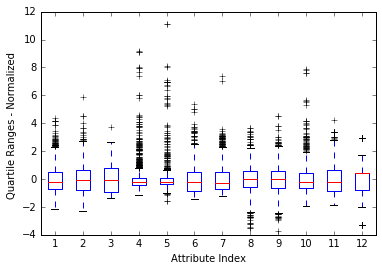

In [9]:
boxplot(data_scaled)
plt.xlabel("Attribute Index")
plt.ylabel(("Quartile Ranges - Normalized "))
show() # run this cell prior to importing seaborn

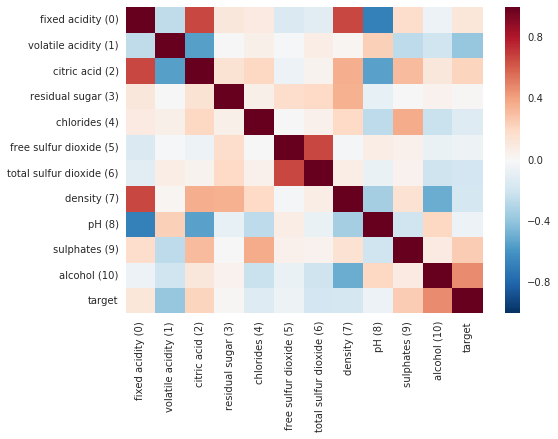

In [10]:
import seaborn as sns
corr_matrx = df.corr()
sns.heatmap(corr_matrx)

In [11]:
short_col = ['fixAcid', 'volAcid', 'citAcid', 'resSugr', 'chlor', 'frSO2', 'totSO2', 'dens', 
             'pH', 'sulpha', 'alcohol', 'quality']
cormat = np.array(corr_matrx).tolist()
for i in range(len(cormat)):
    for j in range(len(cormat)):
        cormat[i][j] = round(cormat[i][j], 2)
corr_matrx = pd.DataFrame(cormat, columns=short_col, index=short_col)
corr_matrx

,fixAcid,volAcid,citAcid,resSugr,chlor,frSO2,totSO2,dens,pH,sulpha,alcohol,quality
fixAcid,1.00,-0.26,0.67,0.11,0.09,-0.15,-0.11,0.67,-0.68,0.18,-0.06,0.12
volAcid,-0.26,1.00,-0.55,0.00,0.06,-0.01,0.08,0.02,0.23,-0.26,-0.20,-0.39
citAcid,0.67,-0.55,1.00,0.14,0.20,-0.06,0.04,0.36,-0.54,0.31,0.11,0.23
resSugr,0.11,0.00,0.14,1.00,0.06,0.19,0.20,0.36,-0.09,0.01,0.04,0.01
chlor,0.09,0.06,0.20,0.06,1.00,0.01,0.05,0.20,-0.27,0.37,-0.22,-0.13
frSO2,-0.15,-0.01,-0.06,0.19,0.01,1.00,0.67,-0.02,0.07,0.05,-0.07,-0.05
totSO2,-0.11,0.08,0.04,0.20,0.05,0.67,1.00,0.07,-0.07,0.04,-0.21,-0.19
dens,0.67,0.02,0.36,0.36,0.20,-0.02,0.07,1.00,-0.34,0.15,-0.50,-0.17
pH,-0.68,0.23,-0.54,-0.09,-0.27,0.07,-0.07,-0.34,1.00,-0.20,0.21,-0.06
sulpha,0.18,-0.26,0.31,0.01,0.37,0.05,0.04,0.15,-0.20,1.00,0.09,0.25


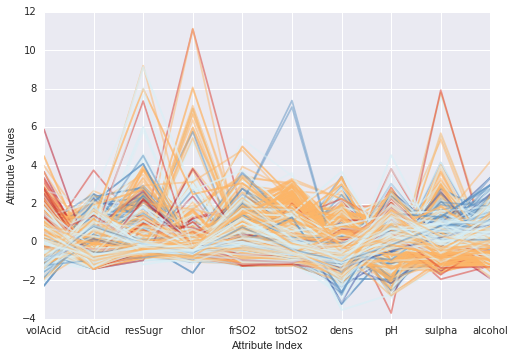

In [12]:
n_rows = len(df.index)
n_data_cols = len(df.columns) - 1
df_norm = pd.DataFrame(data_scaled, columns = short_col)
for i in range(n_rows):
    data_row = df_norm.iloc[i,1:n_data_cols]   # plot rows of data 
    norm_target = df_norm.iloc[i,n_data_cols]
    labelColor = 1.0/(1.0 + np.exp(-norm_target))
    data_row.plot(color=plt.cm.RdYlBu(labelColor), alpha=0.5)
plt.xlabel("Attribute Index")
plt.ylabel(("Attribute Values"))
plt.show()

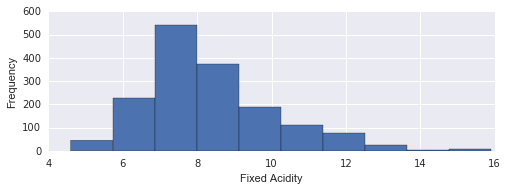

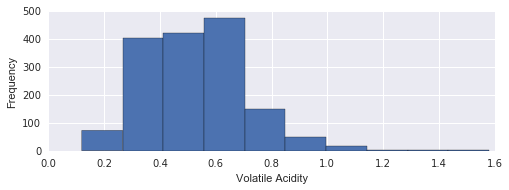

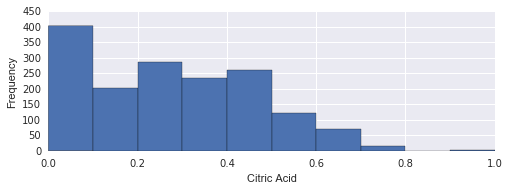

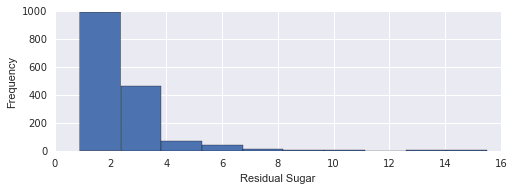

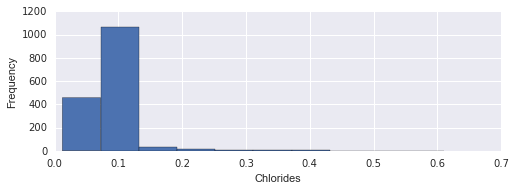

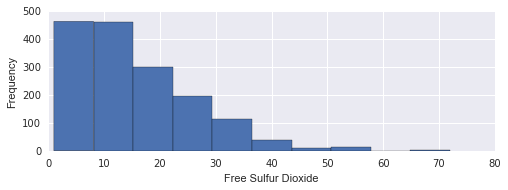

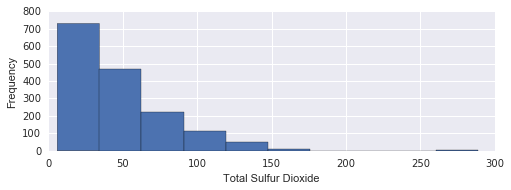

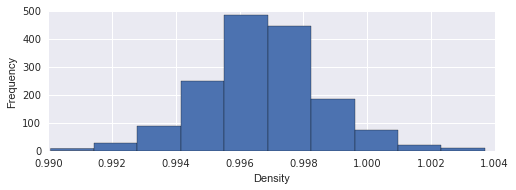

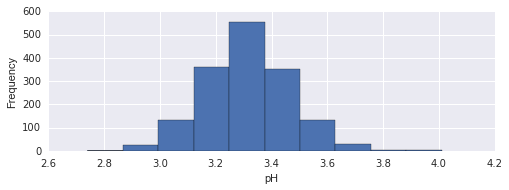

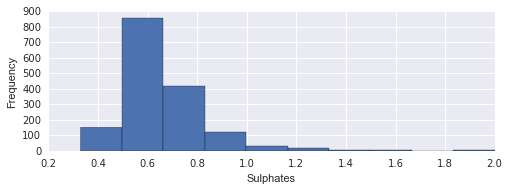

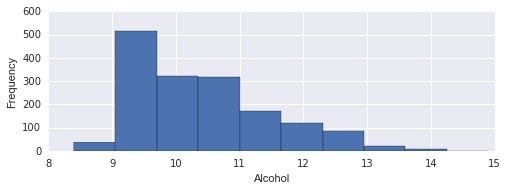

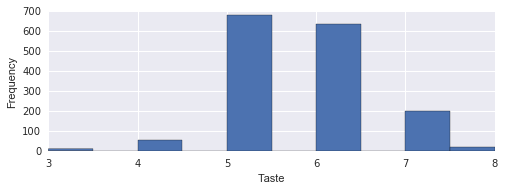

In [13]:
fa = df['fixed acidity (0)']
va = df['volatile acidity (1)']
ca = df['citric acid (2)']
rs = df['residual sugar (3)']
ch = df['chlorides (4)']
fs = df['free sulfur dioxide (5)']
ts = df['total sulfur dioxide (6)'] 
de = df['density (7)']
ph = df['pH (8)'] 
su = df['sulphates (9)'] 
al = df['alcohol (10)']
qu = df['target']

fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
n, bins, patches = ax1.hist(fa)
ax1.set_xlabel('Fixed Acidity')
ax1.set_ylabel('Frequency')

fig2 = plt.figure()
ax2 = fig2.add_subplot(2, 1, 1)
n, bins, patches = ax2.hist(va)
ax2.set_xlabel('Volatile Acidity')
ax2.set_ylabel('Frequency')

fig3 = plt.figure()
ax3 = fig3.add_subplot(2, 1, 1)
n, bins, patches = ax3.hist(ca)
ax3.set_xlabel('Citric Acid')
ax3.set_ylabel('Frequency')

fig4 = plt.figure()
ax4 = fig4.add_subplot(2, 1, 1)
n, bins, patches = ax4.hist(rs)
ax4.set_xlabel('Residual Sugar')
ax4.set_ylabel('Frequency')

fig5 = plt.figure()
ax5 = fig5.add_subplot(2, 1, 1)
n, bins, patches = ax5.hist(ch)
ax5.set_xlabel('Chlorides')
ax5.set_ylabel('Frequency')

fig6 = plt.figure()
ax6 = fig6.add_subplot(2, 1, 1)
n, bins, patches = ax6.hist(fs)
ax6.set_xlabel('Free Sulfur Dioxide')
ax6.set_ylabel('Frequency')

fig7 = plt.figure()
ax7 = fig7.add_subplot(2, 1, 1)
n, bins, patches = ax7.hist(ts)
ax7.set_xlabel('Total Sulfur Dioxide')
ax7.set_ylabel('Frequency')

fig8 = plt.figure()
ax8 = fig8.add_subplot(2, 1, 1)
n, bins, patches = ax8.hist(de)
ax8.set_xlabel('Density')
ax8.set_ylabel('Frequency')

fig9 = plt.figure()
ax9 = fig9.add_subplot(2, 1, 1)
n, bins, patches = ax9.hist(ph)
ax9.set_xlabel('pH')
ax9.set_ylabel('Frequency')

fig10 = plt.figure()
ax10 = fig10.add_subplot(2, 1, 1)
n, bins, patches = ax10.hist(su)
ax10.set_xlabel('Sulphates')
ax10.set_ylabel('Frequency')

fig11 = plt.figure()
ax11 = fig11.add_subplot(2, 1, 1)
n, bins, patches = ax11.hist(al)
ax11.set_xlabel('Alcohol')
ax11.set_ylabel('Frequency')

fig12 = plt.figure()
ax12 = fig12.add_subplot(2, 1, 1)
n, bins, patches = ax12.hist(qu)
ax12.set_xlabel('Taste')
ax12.set_ylabel('Frequency')

In [14]:
x = df[list(df.columns)[:-1]]
y = df['target']
x = sm.add_constant(x)  #include intercept, since x is not scaled
modl = sm.OLS(y, x).fit()  #y goes before x in statsmodels
modl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Mon, 14 Nov 2016   Prob (F-statistic):          1.79e-145
Time:                        00:06:20   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:                    1587   BIC:                             3227.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
const                       21.9652     21.195      1.036      0.300       -19.607    63.538
fixed acidity (0)            0.0250      0.026      0.963      0.336        -0.026     0.076
volatile acidity (1)        -1.0836      0.121     -8.948      0.000        -1.321    -0.846
citric acid (2)             -0.1826      0.147     -1.240      0.215        -0.471     0.106
residual sugar (3)           0.0163      0.015      1.089      0.276        -0.013     0.046
chlorides (4)               -1.8742      0.419     -4.470      0.000        -2.697    -1.052
free sulfur dioxide (5)      0.0044      0.002      2.009      0.045         0.000     0.009
total sulfur dioxide (6)    -0.0033      0.001     -4.480      0.000        -0.005    -0.002
density (7)                -17.8812     21.633     -0.827      0.409       -60.314    24.551
pH (8)                      -0.4137      0.192     -2.159      0.031        -0.789    -0.038
sulphates (9)                0.9163      0.114      8.014      0.000         0.692     1.141
alcohol (10)                 0.2762      0.026     10.429      0.000         0.224     0.328
==============================================================================
Omnibus:                       27.376   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.965
Skew:                          -0.168   Prob(JB):                     1.27e-09
Kurtosis:                       3.708   Cond. No.                     1.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
df.target.value_counts() 

5    681
6    638
7    199
4     53
8     18
3     10
Name: target, dtype: int64

## Models & Algorithms

1.  Stepwise Algorithm <br>
2.  Linear Regression <br>
3.  Linear (Stepwise) Regr <br>
4.  Gradient Descent, from scratch, x scaled <br>
5.  Gradient Descent, sklearn, x scaled <br>
6.  Gradient Descent 7 features, from scratch, x scaled <br>
7.  Gradient Descent 7 features, sklearn, x scaled  <br>
8.  Ridge, from scratch, x scaled, alphas <br>
9.  Ridge, sklearn, alphas <br>
10. Ridge alpha .0001, from scratch, x scaled <br> 
11. Ridge alpha 1, sklearn <br>
12. Ridge 7 features, alpha .0001, from scratch, x scaled <br>
13. Ridge 7 features, alpha 1, sklearn  <br>
14. Lars Algorithm, from scratch <br>
15. Lars, from scratch, xy scaled <br>
16. Lasso, alphas, sklearn <br>
17. Lasso alpha 0.01, sklearn, xy scaled <br> 
18. Lasso alpha 0.01, sklearn, x scaled <br> 
19. ElasticNet grid search for L1 ratio

#### 1. Stepwise Algorithm 

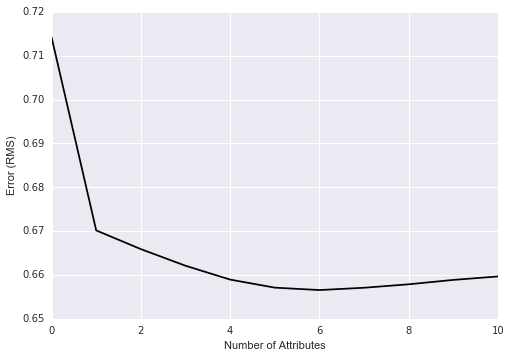

Out of sample error versus attribute set size
[0.71422610507564765, 0.67015915718770025, 0.6658948255733077, 0.66210322905841368, 0.65894318547313158, 0.65710566704274365, 0.65655619653940922, 0.65708294716302151, 0.65787039535648484, 0.65887165001454129, 0.65966046088820485]

Best attribute indices
[10, 1, 9, 4, 6, 8, 5, 2, 3, 7, 0]

Best attribute names
['alcohol (10)', 'volatile acidity (1)', 'sulphates (9)', 'chlorides (4)', 'total sulfur dioxide (6)', 'pH (8)', 'free sulfur dioxide (5)', 'citric acid (2)', 'residual sugar (3)', 'density (7)', 'fixed acidity (0)']

Rmse Results of Forward Stepwise Regression


,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5),citric acid (2),residual sugar (3),density (7),fixed acidity (0)
RMSE,0.714226,0.670159,0.665895,0.662103,0.658943,0.657106,0.656556,0.657083,0.65787,0.658872,0.65966


In [17]:
#index list positions 
index_positions = range(len(x_list))
x_list_ = [x_list[i] for i in index_positions]
y_ = [labels[i] for i in index_positions]

#try each feature to see which one gives least oos error
stepwise_indices = []
indx = range(len(x_list_[1]))
index_set = set(indx)
oos_error = []
for i in indx:
    feature_set = set(stepwise_indices)
    try_set = index_set - feature_set
    try_list = [i for i in try_set]  
    error_list, temp_list = [], []
    for feat in try_list:  
        temp_list = [] + stepwise_indices
        temp_list.append(feat)
        xTemp = x_features_cols(x_list_, temp_list) #add next feature to dataset
        x_ = np.array(xTemp); y_ = np.array(y_)  #convert to numpy arrays
        modl = LinearRegression()  
        modl.fit(x_, y_)
        step_preds = cross_val_predict(modl, x_, y_, cv=10) #make predictions
        rms_error = calc_rmse(step_preds, y_)  #calculate errors
        error_list.append(rms_error)
        temp_list = []
    iBest = np.argmin(error_list)
    stepwise_indices.append(try_list[iBest])
    oos_error.append(error_list[iBest])
    
#plot error versus number of attributes
xaxis = range(len(oos_error))
plt.plot(xaxis, oos_error, 'k')
plt.xlabel('Number of Attributes')
plt.ylabel('Error (RMS)')
plt.show()

print('Out of sample error versus attribute set size')
print(oos_error)
print('\nBest attribute indices')
print(stepwise_indices)
stepwise_sequence = [df.columns[i] for i in stepwise_indices]
print('\nBest attribute names')
print(stepwise_sequence)
oos_rounded = []
for i in oos_error:
    oos_rounded.append(round(i,7))
df_features = pd.DataFrame(zip(oos_rounded), index = stepwise_sequence, columns = ['RMSE'])
print '\nRmse Results of Forward Stepwise Regression'
df_features.T

#### 2. Linear Regression 

In [18]:
def run_linear_regr_2(x, y):
    modl = LinearRegression()
    modl.fit(x, y)
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Linear Regr', preds, modl.coef_, modl.intercept_, stepwise_sequence, y)

#### 3. Linear (Stepwise) Regression 

In [19]:
def run_stepwise_3(x, y):
    modl = LinearRegression()
    modl.fit(x, y)
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Linear (Stepwise) Regr', preds, modl.coef_, modl.intercept_, 
                  stepwise_sequence[0:7], y)

#### 4. Gradient Descent, from scratch, x scaled 

In [20]:
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = zip(x, y)
    theta = theta_0   # theta-initial guess
    alpha = alpha_0   # alpha-initial step size
    min_theta = None  # the minimum so far
    min_value = float("inf") 
    iterations_with_no_improvement = 0
    while iterations_with_no_improvement < 100: 
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)
        # if we've found a new minimum, remember it & go back to the original step size
        if value < min_value: 
            min_theta = theta
            min_value = value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:  # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9
        for x_i, y_i in in_random_order(data):
            # and take a gradient step for each of the data points
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = np.subtract(theta, np.multiply(alpha, gradient_i)) 
    return min_theta

In [26]:
def sqd_err_gradient(x_i, y_i, beta):  
    return [-2 * x_ij * regr_error(x_i, y_i, beta) for x_ij in x_i]

def sqd_err_regr(x_i, y_i, beta):  
    return regr_error(x_i, y_i, beta) ** 2

def estimate_beta_sgd(x, y):  
    beta_initial = [random.random() for x_i in x[0]]
    beta = minimize_stochastic(sqd_err_regr, sqd_err_gradient, x, y, beta_initial, 0.001)
    return beta

def run_gradient_descent_4(x, y):
    random.seed(0)
    beta = estimate_beta_sgd(x, y)
    preds = calc_pred_vals(x[:,1:], beta[1:], beta[0])
    coefs = beta[1:]
    coefs = [coefs[i] for i in stepwise_indices] #use stepwise sequence
    model_details('Gradient Descent, from scratch, x scaled', preds, coefs, 
                  beta[0], stepwise_sequence, y)

#### 5. Gradient Descent, sklearn, x scaled 

In [22]:
def run_gradient_descent_5(x, y):
    modl = SGDRegressor(penalty='none', random_state=0)
    modl.fit(x, y)
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Gradient Descent, sklearn, x scaled', preds, modl.coef_, 
                  modl.intercept_, stepwise_sequence, y)

#### 6. Gradient Descent 7 features, from scratch, x scaled 

In [23]:
def run_gr_des_6(x, y):
    random.seed(0)
    beta = estimate_beta_sgd(x, y)
    preds = calc_pred_vals(x[:,1:], beta[1:], beta[0])
    coefs = beta[1:]
    model_details('Gradient Descent 7 features, from scratch, x scaled', preds, coefs, 
                  beta[0], stepwise_sequence[0:7], y)

#### 7. Gradient Descent 7 features, sklearn, x scaled

In [24]:
def run_gradient_descent_7(x, y):
    modl = SGDRegressor(penalty='none', random_state=0)
    modl.fit(x, y) 
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Gradient Descent 7 features, sklearn, x scaled', preds, modl.coef_, 
                  modl.intercept_, stepwise_sequence[0:7], y)

#### 8. Ridge, from scratch, x scaled, alphas

In [27]:
def ridge_penalty(beta, alpha):
    return alpha * np.dot(beta[1:], beta[1:])

def ridge_penalty_gradient(beta, alpha):# gradient of just the ridge penalty
    return [0] + [2 * alpha * beta_j for beta_j in beta[1:]]

def sqd_err_ridge(x_i, y_i, beta, alpha): 
    # estimate error plus ridge penalty on beta
    return regr_error(x_i, y_i, beta) ** 2 + ridge_penalty(beta, alpha)

def sqd_err_ridge_gradient(x_i, y_i, beta, alpha): 
    # gradient corresponding to the ith squared error term incl the ridge penalty
    return np.add(sqd_err_gradient(x_i, y_i, beta), ridge_penalty_gradient(beta, alpha))

# use gradient descent to fit a ridge regression with penalty alpha
def estimate_beta_ridge(x, y, alpha): 
    beta_initial = [random.random() for x_i in x[0]]
    return minimize_stochastic(partial(sqd_err_ridge, alpha=alpha), 
                               partial(sqd_err_ridge_gradient, alpha=alpha), 
                               x, y, beta_initial, 0.001)

import random
x = sm.add_constant(x_scaled)
y = labels
random.seed(0)
print 'Ridge (alphas) from scratch, x scaled'
for alpha in [.001, .01, .1, 1]:
    beta = estimate_beta_ridge(x, y, alpha=alpha)
    print '\nalpha:', alpha 
    print 'betas in original feature sequence\n', beta
    preds = calc_pred_vals(x[:,1:], beta[1:], beta[0])
    rdg_rmse = calc_rmse(preds, y)  
    print 'RMSE', rdg_rmse

Ridge (alphas) from scratch, x scaled

alpha: 0.001
betas in original feature sequence
[ 5.63608689  0.04458975 -0.19338628 -0.03500814  0.02327866 -0.08818733
  0.04531508 -0.10701855 -0.03518182 -0.06295224  0.155479    0.29344029]
RMSE 0.645575566762

alpha: 0.01
betas in original feature sequence
[ 5.6361688   0.04679496 -0.19103562 -0.03073406  0.02469915 -0.08754937
  0.04380035 -0.10579913 -0.03973667 -0.05925171  0.15471232  0.287881  ]
RMSE 0.645598066235

alpha: 0.1
betas in original feature sequence
[  5.63604572e+00   5.34512179e-02  -1.73383474e-01  -3.40371984e-03
   2.72588496e-02  -8.25957742e-02   3.33200122e-02  -9.62613159e-02
  -5.95472430e-02  -4.02508110e-02   1.44626869e-01   2.55660171e-01]
RMSE 0.646794314071

alpha: 1
betas in original feature sequence
[  5.63607553e+00   3.15324244e-02  -1.10421700e-01   4.01280047e-02
   1.30703326e-02  -4.83143468e-02   2.94470958e-03  -5.50722456e-02
  -5.31323276e-02  -1.31208573e-02   8.35176071e-02   1.52876707e-01]
RMS

#### 9. Ridge, sklearn, alphas

In [28]:
x = df[stepwise_sequence]
y = df['target']
alpha_list = [0.1, 1, 10]  #use a range of alphas
error_list = []
for alph in alpha_list:
    modl = Ridge(alpha=alph) 
    modl.fit(x, y)   
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    rms_error = calc_rmse(preds, y)  #calculate errors
    error_list.append(rms_error)
print("RMS Error             alpha")
for i in range(len(error_list)):
    print(error_list[i], alpha_list[i])

RMS Error             alpha
(0.65895530384808398, 0.1)
(0.65888313822882527, 1)
(0.66101735274064799, 10)


#### 10. Ridge alpha .001, from scratch, x scaled

In [29]:
def run_ridge_10(x, y):
    random.seed(0)
    beta = estimate_beta_ridge(x, y, alpha=.001)
    preds = calc_pred_vals(x[:,1:], beta[1:], beta[0])
    coefs = beta[1:]
    coefs = [coefs[i] for i in stepwise_indices] 
    model_details('Ridge alpha .001, from scratch, x scaled', preds, coefs, beta[0], 
                  stepwise_sequence, y)

#### 11. Ridge alpha 1, sklearn

In [30]:
def run_ridge_11(x, y):
    modl = Ridge(alpha=1)
    modl.fit(x, y) 
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Ridge alpha 1, sklearn', preds, modl.coef_, modl.intercept_, 
                  stepwise_sequence, y)

#### 12. Ridge 7 features, alpha .001, from scratch, x scaled

In [31]:
def run_ridge_12(x, y):
    random.seed(0)
    beta = estimate_beta_ridge(x, y, alpha=.001)
    preds = calc_pred_vals(x[:,1:], beta[1:], beta[0])
    coefs = beta[1:]
    model_details('Ridge 7 features, alpha .001, from scratch, x scaled', preds, coefs, 
                  beta[0], stepwise_sequence[0:7], y)

#### 13. Ridge 7 features, alpha 1, sklearn

In [32]:
def run_ridge_13(x, y):
    modl = Ridge(alpha=1)
    modl.fit(x, y) 
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Ridge 7 features, alpha 1, sklearn', preds, modl.coef_, modl.intercept_, 
                  stepwise_sequence[0:7], y)

#### 14. Lars Algorithm

index of betas with lowest rmse 338   minimum rmse 0.799685719012

coefficients in original feature order
[('fixed acidity (0)', 0.036000000000000004), ('volatile acidity (1)', -0.24000000000000019), ('citric acid (2)', -0.040000000000000008), ('residual sugar (3)', 0.024), ('chlorides (4)', -0.11200000000000007), ('free sulfur dioxide (5)', 0.060000000000000026), ('total sulfur dioxide (6)', -0.13600000000000009), ('density (7)', -0.028000000000000001), ('pH (8)', -0.08800000000000005), ('sulphates (9)', 0.19200000000000014), ('alcohol (10)', 0.37200000000000027)]

feature priority under LARS algorithm
['alcohol (10)', 'volatile acidity (1)', 'sulphates (9)', 'total sulfur dioxide (6)', 'chlorides (4)', 'fixed acidity (0)', 'pH (8)', 'free sulfur dioxide (5)', 'citric acid (2)', 'residual sugar (3)', 'density (7)']


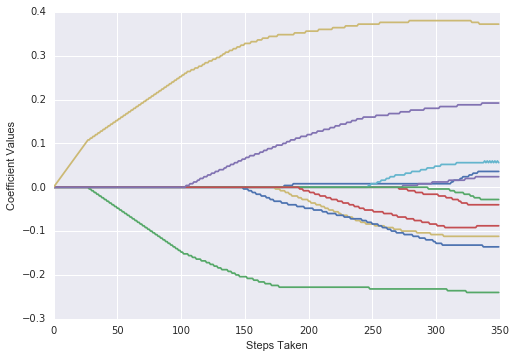

In [33]:
n_cols = len(x_list[0])
beta = [0.0] * n_cols # row of beta coefficients
beta_matrix = [] # matrix of beta coefficients
beta_matrix.append(list(beta))
n_steps = 350
step_size = 0.004
lars_indices = [] # features placement sequence

# calculate correlation between features & residuals
# and increment (decrement) beta corresponding to feature with highest correlation 
for i in range(n_steps):
    residuals = [0.0] * n_rows
    for j in range(n_rows):
        labels_hat = sum([x_scaled[j][k] * beta[k] for k in range(n_cols)])
        residuals[j] = labels_scaled[j] - labels_hat
    corr = [0.0] * n_cols    
    for j in range(n_cols):
        corr[j] = sum([x_scaled[k][j] * residuals[k] for k in range(n_rows)]) / n_rows
    k = 0    
    corr_i = corr[0]
    for j in range(1, (n_cols)):
        if abs(corr_i) < abs(corr[j]):
            k = j
            corr_i = corr[j]
    beta[k] += step_size * corr_i / abs(corr_i)
    beta_matrix.append(list(beta))
    beta_indices = [index for index in range(n_cols) if beta[index] != 0.0]
    for q in beta_indices:
        if (q in lars_indices) == False:
            lars_indices.append(q)

#find the beta matrix index with lowest rmse
errors = []
x = np.array(df_scaled).tolist()  #list of list format for calc_pre_vals
y = labels_scaled
for i in range(len(beta_matrix)):
    preds = calc_pred_vals(x, beta_matrix[i])
    rms_error = calc_rmse(preds, y)
    errors.append(rms_error)
min_error = min(errors)
min_index = errors.index(min_error)
print 'index of betas with lowest rmse', min_index, '  minimum rmse', min_error
    
#plot range of beta values for each attribute
for i in range(n_cols):
    coeff_curve = [beta_matrix[k][i] for k in range(n_steps)]
    xaxis = range(n_steps)
    plt.plot(xaxis, coeff_curve)
print '\ncoefficients in original feature order'
dfnames = df.columns
coeffs = beta_matrix[min_index]
print (zip(dfnames, coeffs))  
lars_sequence = [dfnames[lars_indices[i]] for i in range(len(lars_indices))]  
lars_coeffs = [coeffs[i] for i in lars_indices]
print '\nfeature priority under LARS algorithm\n', lars_sequence
plt.xlabel("Steps Taken")
plt.ylabel(("Coefficient Values"))
plt.show()

#### 15. Lars, from scratch, xy scaled

In [52]:
def run_lars_15(x, y):
    preds = calc_pred_vals(x, lars_coeffs)  # lars_coeffs is global; no intercept
    model_details('Lars, from scratch, xy scaled', preds, lars_coeffs, 0, lars_sequence, 
                  y, False)

#### 16. Lasso, alphas, sklearn

In [35]:
x = df_scaled[lars_sequence]
y = labels_scaled
alpha_list = [0.001, 0.01, 0.1]  
error_list = []
for alph in alpha_list:
    modl = Lasso(alpha=alph, normalize=False) 
    modl.fit(x, y)   
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    rms_error = calc_rmse(preds, y)  #calculate errors
    error_list.append(rms_error)
print 'x and y scaled'
print("RMS Error             alpha")
for i in range(len(error_list)):
    print(error_list[i], alpha_list[i])

y = df['target']
alpha_list = [0.001, 0.01, 0.1]  
error_list = []
for alph in alpha_list:
    modl = Lasso(alpha=alph, normalize=False) 
    modl.fit(x, y)   
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    rms_error = calc_rmse(preds, y)  #calculate errors
    error_list.append(rms_error)
print '\nx scaled  (labels not scaled)'
print("RMS Error             alpha")
for i in range(len(error_list)):
    print(error_list[i], alpha_list[i])

x and y scaled
RMS Error             alpha
(0.81708174767321784, 0.001)
(0.8160103265216736, 0.01)
(0.83789547968910716, 0.1)

x scaled  (labels not scaled)
RMS Error             alpha
(0.65963738656123083, 0.001)
(0.65863795393371882, 0.01)
(0.68208758146391235, 0.1)


#### 17. Lasso alpha 0.01, sklearn, xy scaled

In [36]:
def run_lasso_17(x, y):
    modl = Lasso(alpha=0.01, normalize=False)
    modl.fit(x,y)
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Lasso alpha 0.01, sklearn, xy scaled', preds, modl.coef_, 
                  modl.intercept_, lars_sequence, y, False)

#### 18. Lasso alpha 0.01, sklearn, x scaled

In [37]:
def run_lasso_18(x, y):
    modl = Lasso(alpha=0.01, normalize=False)
    modl.fit(x,y)
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Lasso alpha 0.01, sklearn, x scaled', preds, modl.coef_, 
                  modl.intercept_, lars_sequence, y)

#### 19. ElasticNet grid search for L1 ratio

In [39]:
selected_cols = lars_sequence  
x = df_scaled[selected_cols]
y = labels_scaled
enet_p = {'l1_ratio' : [0, 1e-10, .1, .3, .5, .7, .9, 1]}                                    
enet = ElasticNet()                                   # instantiate model
enet_grid = GridSearchCV(enet, enet_p, cv=5)          # instantiate grid
enet_grid.fit(x, y)                                   # fit grid with data
print "best parameters: \n", enet_grid.best_params_   # print best parameters

best parameters: 
{'l1_ratio': 0}


In [40]:
# create lists for storing details
modl_name = [] # name for model
rmse = [] # root mean square error
accuracy = [] # overall accuracy
cmats = [] # confusion matrix dataframe
cmat_sum = [] # to confirm no results are missing
df_beta_coefs = [] # coefficients dataframe

In [41]:
# results of Stepwise Algorithm #1 appear in prior section
run_linear_regr_2(df[stepwise_sequence], df['target'])

In [42]:
run_stepwise_3(df[stepwise_sequence[0:7]], df['target'])

In [43]:
run_gradient_descent_4(sm.add_constant(x_scaled), labels)

In [44]:
run_gradient_descent_5(df_scaled[stepwise_sequence], df['target'])

In [45]:
run_gr_des_6(sm.add_constant(np.array(df_scaled[stepwise_sequence[0:7]]).tolist()), labels)

In [46]:
run_gradient_descent_7(df_scaled[stepwise_sequence[0:7]], df['target'])

In [47]:
#results for Ridge alphas #8 & #9 appear in prior section
run_ridge_10(sm.add_constant(x_scaled), labels)

In [48]:
run_ridge_11(df[stepwise_sequence], df['target'])

In [49]:
run_ridge_12(sm.add_constant(np.array(df_scaled[stepwise_sequence[0:7]]).tolist()), labels)

In [50]:
run_ridge_13(df[stepwise_sequence[0:7]], df['target'])

In [61]:
#results of Lars Algorithm #14 appear in prior section
run_lars_15(np.array(df_scaled[lars_sequence]).tolist(), labels_scaled)

In [54]:
#results for Lasso alphas #16 appear in prior section
run_lasso_17(df_scaled[lars_sequence], labels_scaled)

In [55]:
run_lasso_18(df_scaled[lars_sequence], df['target'])

In [56]:
df_scores = pd.DataFrame(zip(rmse, accuracy), columns = ['RMSE', 'Overall Accuracy'], 
                         index = modl_name)
df_scores

,RMSE,Overall Accuracy
Linear Regr,0.659660,0.589118
Linear (Stepwise) Regr,0.656556,0.587242
"Gradient Descent, from scratch, x scaled",0.645575,0.59162
"Gradient Descent, sklearn, x scaled",0.659644,0.590994
"Gradient Descent 7 features, from scratch, x scaled",0.646121,0.592871
"Gradient Descent 7 features, sklearn, x scaled",0.656390,0.589744
"Ridge alpha .001, from scratch, x scaled",0.645576,0.59162
"Ridge alpha 1, sklearn",0.658883,0.587867
"Ridge 7 features, alpha .001, from scratch, x scaled",0.646121,0.592871
"Ridge 7 features, alpha 1, sklearn",0.656660,0.586617


In [57]:
df_beta_coefs[4]

,intercept,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5)
"Gradient Descent 7 features, from scratch, x scaled",5.63607,0.30813,-0.18165,0.14945,-0.09477,-0.11436,-0.07447,0.05298


In [58]:
df_beta_coefs[8]

,intercept,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5)
"Ridge 7 features, alpha .001, from scratch, x scaled",5.63607,0.30786,-0.18161,0.14932,-0.09466,-0.11415,-0.07431,0.05276


In [63]:
rmse[13]

0.79968571901227326

In [60]:
df_beta_coefs[11]

,intercept,alcohol (10),volatile acidity (1),sulphates (9),total sulfur dioxide (6),chlorides (4),fixed acidity (0),pH (8),free sulfur dioxide (5),citric acid (2),residual sugar (3),density (7)
"Lasso alpha 0.01, sklearn, xy scaled",0.0,0.37649,-0.22697,0.17273,-0.11069,-0.10056,0.0,-0.07397,0.0333,-0.0,0.00287,-0.0


In [64]:
outliers_upper, outliers_lower = [], []
for i in range(len(stats.columns)-1):
    inter_quartile_range = stats.iloc[6,i] - stats.iloc[4,i]
    limit_upper = stats.iloc[6,i] + 1.5 * inter_quartile_range
    limit_lower = stats.iloc[4,i] - 1.5 * inter_quartile_range
    outliers_upper.append(df.loc[df[df.columns[i]] > limit_upper])
    outliers_lower.append(df.loc[df[df.columns[i]] < limit_lower])
    print '\n', df.columns[i], '\noutliers are anything above', limit_upper, 
    print '  max val:', stats.iloc[7,i], '  # of outliers:', 
    print len(outliers_upper[i]), '\nor below', limit_lower, '  min value is:', 
    print stats.iloc[4,i], '   # of outliers is', len(outliers_lower[i])


fixed acidity (0) 
outliers are anything above 12.35   max val: 15.9   # of outliers: 49 
or below 3.95   min value is: 7.1    # of outliers is 0

volatile acidity (1) 
outliers are anything above 1.015   max val: 1.58   # of outliers: 19 
or below 0.015   min value is: 0.39    # of outliers is 0

citric acid (2) 
outliers are anything above 0.915   max val: 1.0   # of outliers: 1 
or below -0.405   min value is: 0.09    # of outliers is 0

residual sugar (3) 
outliers are anything above 3.65   max val: 15.5   # of outliers: 155 
or below 0.85   min value is: 1.9    # of outliers is 0

chlorides (4) 
outliers are anything above 0.12   max val: 0.611   # of outliers: 103 
or below 0.04   min value is: 0.07    # of outliers is 9

free sulfur dioxide (5) 
outliers are anything above 42.0   max val: 72.0   # of outliers: 30 
or below -14.0   min value is: 7.0    # of outliers is 0

total sulfur dioxide (6) 
outliers are anything above 122.0   max val: 289.0   # of outliers: 55 
or below -

In [69]:
# next step - delete outliers in 7 stepwise columns only
df = df.loc[df['alcohol (10)'] < 13.5]
df.shape

(1585, 12)